In [1]:
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMClassifier, Dataset, cv, train, early_stopping
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import __version__ as sklearn_version
from packaging import version
from multiprocessing import cpu_count
import numpy as np
import shap
import matplotlib.pyplot as plt
import polars as pl
import itertools
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Development 

### For some antibtiocs you need to train on both inpatient and outpatient data.
### use the first cell to load both datasets and combine them.
### use the second cell to only load outpatient data.

In [ ]:


df=pd.read_csv('Model1_AllABX_Outpatients_fixTime0.csv') # for including Comorbidites use Model1_with_Comorbidity_components.csv
df2=pd.read_csv('Model1_AllABX_Inpatients_fixTime0.csv')
df['ordering_setting']='OUTPATIENT'
df2['ordering_setting']='INPATIENT'
df=pd.concat([df,df2],axis=0)
df=df[df.culture_description!='RESPIRATORY'] # Exclude respiratory cultures or you can keep them. 
df.head()

In [ ]:
df=pd.read_csv('Model1_AllABX_Outpatients_fixTime0.csv') # for including Comorbidities use Model1_with_Comorbidity_components
df=df[df.culture_description!='RESPIRATORY'] # Exclude respiratory cultures or you can keep them. 
df.head()

In [ ]:
categorical_features=['antibiotic','implied_susceptibility','culture_description']
comorbidities_features=['comorbidity_Abdominal hernia',
 'comorbidity_Abdominal pain and other digestive/abdomen signs and symptoms',
 'comorbidity_Abnormal findings related to substance use',
 'comorbidity_Abnormal findings without diagnosis',
 'comorbidity_Acquired absence of limb or organ',
 'comorbidity_Acquired deformities (excluding foot)',
 'comorbidity_Acquired foot deformities',
 'comorbidity_Acute and chronic tonsillitis',
 'comorbidity_Acute and unspecified renal failure',
 'comorbidity_Acute bronchitis',
 'comorbidity_Acute hemorrhagic cerebrovascular disease',
 'comorbidity_Acute myocardial infarction',
 'comorbidity_Acute phlebitis; thrombophlebitis and thromboembolism',
 'comorbidity_Acute pulmonary embolism',
 'comorbidity_Acute rheumatic heart disease',
 'comorbidity_Adverse effects of drugs and medicaments, initial encounter',
 'comorbidity_Adverse effects of drugs and medicaments, subsequent encounter',
 'comorbidity_Alcohol abuse',
 'comorbidity_Alcohol-related disorders',
 'comorbidity_Allergic reactions',
 'comorbidity_Allergic reactions, subsequent encounter',
 'comorbidity_Amputation of a limb, initial encounter',
 'comorbidity_Amputation of a limb, subsequent encounter',
 'comorbidity_Amputation of other body parts, initial encounter',
 'comorbidity_Amputation of other body parts, subsequent encounter',
 'comorbidity_Anal and rectal conditions',
 'comorbidity_Anesthesia complications during pregnancy',
 'comorbidity_Antenatal screening',
 'comorbidity_Anxiety and fear-related disorders',
 'comorbidity_Aortic and peripheral arterial embolism or thrombosis',
 'comorbidity_Aortic; peripheral; and visceral artery aneurysms',
 'comorbidity_Aplastic anemia',
 'comorbidity_Appendicitis and other appendiceal conditions',
 'comorbidity_Arterial dissections',
 'comorbidity_Aseptic necrosis and osteonecrosis',
 'comorbidity_Aspiration pneumonitis',
 'comorbidity_Asthma',
 'comorbidity_Atypical fracture, initial encounter',
 'comorbidity_Atypical fracture, subsequent encounter',
 'comorbidity_Autoinflammatory syndromes',
 'comorbidity_Bacterial infections',
 'comorbidity_Benign neoplasms',
 'comorbidity_Benign ovarian cyst',
 'comorbidity_Biliary tract disease',
 'comorbidity_Biomechanical lesions',
 'comorbidity_Bipolar and related disorders',
 'comorbidity_Birth trauma',
 'comorbidity_Blindness and vision defects',
 'comorbidity_Blood loss anemia',
 'comorbidity_Bone cancer',
 'comorbidity_Breast cancer - all other types',
 'comorbidity_Breast cancer - ductal carcinoma in situ (DCIS)',
 'comorbidity_Burn and corrosion, initial encounter',
 'comorbidity_Burns and corrosion, subsequent encounter',
 'comorbidity_CNS abscess',
 'comorbidity_Calculus of urinary tract',
 'comorbidity_Cancer of other sites',
 'comorbidity_Cannabis-related disorders',
 'comorbidity_Cardiac and circulatory congenital anomalies',
 'comorbidity_Cardiac arrest and ventricular fibrillation',
 'comorbidity_Cardiac arrhythmias',
 'comorbidity_Cardiac cancers',
 'comorbidity_Cardiac dysrhythmias',
 'comorbidity_Carrier status',
 'comorbidity_Cataract and other lens disorders',
 'comorbidity_Cerebral infarction',
 'comorbidity_Cerebral palsy',
 'comorbidity_Chromosomal abnormalities',
 'comorbidity_Chronic kidney disease',
 'comorbidity_Chronic obstructive pulmonary disease and bronchiectasis',
 'comorbidity_Chronic phlebitis; thrombophlebitis and thromboembolism',
 'comorbidity_Chronic pulmonary disease',
 'comorbidity_Chronic rheumatic heart disease',
 'comorbidity_Circulatory signs and symptoms',
 'comorbidity_Cleft lip or palate',
 'comorbidity_Coagulation and hemorrhagic disorders',
 'comorbidity_Coagulopathy',
 'comorbidity_Coma; stupor; and brain damage',
 'comorbidity_Complication of cardiovascular device, implant or graft, initial encounter',
 'comorbidity_Complication of cardiovascular device, implant or graft, subsequent encounter',
 'comorbidity_Complication of genitourinary device, implant or graft, initial encounter',
 'comorbidity_Complication of genitourinary device, implant or graft, subsequent encounter',
 'comorbidity_Complication of internal orthopedic device or implant, initial encounter',
 'comorbidity_Complication of internal orthopedic device or implant, subsequent encounter',
 'comorbidity_Complication of other surgical or medical care, injury, initial encounter',
 'comorbidity_Complication of other surgical or medical care, injury, subsequent encounter',
 'comorbidity_Complication of transplanted organs or tissue, initial encounter',
 'comorbidity_Complication, sequela',
 'comorbidity_Complications following ectopic and/or molar pregnancy',
 'comorbidity_Complications of acute myocardial infarction',
 'comorbidity_Complications specified during childbirth',
 'comorbidity_Complications specified during the puerperium',
 'comorbidity_Conditions due to neoplasm or the treatment of neoplasm',
 'comorbidity_Conduction disorders',
 'comorbidity_Congenital malformations of eye, ear, face, neck',
 'comorbidity_Congestive heart failure',
 'comorbidity_Contact dermatitis',
 'comorbidity_Contraceptive and procreative management',
 'comorbidity_Cornea and external disease',
 'comorbidity_Coronary atherosclerosis and other heart disease',
 'comorbidity_Counseling related to sexual behavior or orientation',
 'comorbidity_Crushing injury, initial encounter',
 'comorbidity_Crushing injury, subsequent encounter',
 'comorbidity_Crystal arthropathies (excluding gout)',
 'comorbidity_Cystic fibrosis',
 'comorbidity_Deficiency anemia',
 'comorbidity_Depression',
 'comorbidity_Depressive disorders',
 'comorbidity_Diabetes mellitus with complication',
 'comorbidity_Diabetes mellitus without complication',
 'comorbidity_Diabetes or abnormal glucose tolerance complicating pregnancy; childbirth; or the puerperium',
 'comorbidity_Diabetes, complicated',
 'comorbidity_Diabetes, uncomplicated',
 'comorbidity_Digestive congenital anomalies',
 'comorbidity_Diseases of inner ear and related conditions',
 'comorbidity_Diseases of middle ear and mastoid (except otitis media)',
 'comorbidity_Diseases of mouth; excluding dental',
 'comorbidity_Diseases of white blood cells',
 'comorbidity_Dislocations, initial encounter',
 'comorbidity_Dislocations, subsequent encounter',
 'comorbidity_Disorders of jaw',
 'comorbidity_Disorders of lipid metabolism',
 'comorbidity_Disorders of teeth and gingiva',
 'comorbidity_Disruptive, impulse-control and conduct disorders',
 'comorbidity_Diverticulosis and diverticulitis',
 'comorbidity_Drug induced or toxic related condition',
 'comorbidity_Dysphagia',
 'comorbidity_Early or threatened labor',
 'comorbidity_Early, first or unspecified trimester hemorrhage',
 'comorbidity_Ectopic pregnancy and complications of ectopic pregnancy',
 'comorbidity_Effect of foreign body entering opening, initial encounter',
 'comorbidity_Effect of foreign body entering opening, subsequent encounter',
 'comorbidity_Effect of other external causes, initial encounter',
 'comorbidity_Effect of other external causes, sequela',
 'comorbidity_Effect of other external causes, subsequent encounter',
 'comorbidity_Encephalitis',
 'comorbidity_Encounter for administrative purposes',
 'comorbidity_Encounter for antineoplastic therapies',
 'comorbidity_Encounter for mental health conditions',
 'comorbidity_Encounter for mental health services related to abuse',
 'comorbidity_Encounter for observation and examination for conditions ruled out (excludes infectious disease, neoplasm, mental disorders)',
 'comorbidity_Encounter for prophylactic measures (excludes immunization)',
 'comorbidity_Encounter for prophylactic or other procedures',
 'comorbidity_Endocarditis and endocardial disease',
 'comorbidity_Endocrine system cancers - adrenocortical',
 'comorbidity_Endocrine system cancers - all other types',
 'comorbidity_Endocrine system cancers - pancreas',
 'comorbidity_Endocrine system cancers - parathyroid',
 'comorbidity_Endocrine system cancers - pituitary gland',
 'comorbidity_Endocrine system cancers - thyroid',
 'comorbidity_Endometriosis',
 'comorbidity_Epilepsy; convulsions',
 'comorbidity_Erectile dysfunction',
 'comorbidity_Esophageal disorders',
 'comorbidity_Exposure, encounters, screening or contact with infectious disease',
 'comorbidity_External cause codes: sequela',
 'comorbidity_External cause codes: subsequent encounter',
 'comorbidity_Feeding and eating disorders',
 'comorbidity_Female infertility',
 'comorbidity_Female reproductive system cancers - all other types',
 'comorbidity_Female reproductive system cancers - cervix',
 'comorbidity_Female reproductive system cancers - endometrium',
 'comorbidity_Female reproductive system cancers - fallopian tube',
 'comorbidity_Female reproductive system cancers - ovary',
 'comorbidity_Female reproductive system cancers - uterus',
 'comorbidity_Female reproductive system cancers - vagina',
 'comorbidity_Female reproductive system cancers - vulva',
 'comorbidity_Fetal alcohol syndrome',
 'comorbidity_Fever',
 'comorbidity_Fluid and electrolyte disorders',
 'comorbidity_Foodborne intoxications',
 'comorbidity_Fracture of head and neck, initial encounter',
 'comorbidity_Fracture of head and neck, subsequent encounter',
 'comorbidity_Fracture of lower limb (except hip), subsequent encounter',
 'comorbidity_Fracture of the lower limb (except hip), initial encounter',
 'comorbidity_Fracture of the neck of the femur (hip), initial encounter',
 'comorbidity_Fracture of the neck of the femur (hip), subsequent encounter',
 'comorbidity_Fracture of the spine and back, initial encounter',
 'comorbidity_Fracture of the spine and back, subsequent encounter',
 'comorbidity_Fracture of the upper limb, initial encounter',
 'comorbidity_Fracture of the upper limb, subsequent encounter',
 'comorbidity_Fracture of torso, initial encounter',
 'comorbidity_Fracture of torso, subsequent encounter',
 'comorbidity_Fungal infections',
 'comorbidity_Gangrene',
 'comorbidity_Gastritis and duodenitis',
 'comorbidity_Gastroduodenal ulcer',
 'comorbidity_Gastrointestinal and biliary perforation',
 'comorbidity_Gastrointestinal cancers - all other types',
 'comorbidity_Gastrointestinal cancers - anus',
 'comorbidity_Gastrointestinal cancers - bile duct',
 'comorbidity_Gastrointestinal cancers - colorectal',
 'comorbidity_Gastrointestinal cancers - esophagus',
 'comorbidity_Gastrointestinal cancers - liver',
 'comorbidity_Gastrointestinal cancers - peritoneum',
 'comorbidity_Gastrointestinal cancers - small intestine',
 'comorbidity_Gastrointestinal cancers - stomach',
 'comorbidity_Gastrointestinal hemorrhage',
 'comorbidity_General sensation/perception signs and symptoms',
 'comorbidity_Genitourinary congenital anomalies',
 'comorbidity_Genitourinary signs and symptoms',
 'comorbidity_Gestational weeks',
 'comorbidity_Glaucoma',
 'comorbidity_Gout',
 'comorbidity_HIV infection',
 'comorbidity_Hallucinogen-related disorders',
 'comorbidity_Head and neck cancers - all other types',
 'comorbidity_Head and neck cancers - eye',
 'comorbidity_Head and neck cancers - hypopharyngeal',
 'comorbidity_Head and neck cancers - laryngeal',
 'comorbidity_Head and neck cancers - lip and oral cavity',
 'comorbidity_Head and neck cancers - nasopharyngeal',
 'comorbidity_Head and neck cancers - pharyngeal',
 'comorbidity_Head and neck cancers - salivary gland',
 'comorbidity_Head and neck cancers - throat',
 'comorbidity_Head and neck cancers - tonsils',
 'comorbidity_Headache; including migraine',
 'comorbidity_Hearing loss',
 'comorbidity_Heart failure',
 'comorbidity_Hematuria',
 'comorbidity_Hemolytic anemia',
 'comorbidity_Hemolytic jaundice and perinatal jaundice',
 'comorbidity_Hemorrhage after first trimester',
 'comorbidity_Hemorrhagic and hematologic disorders of newborn',
 'comorbidity_Hemorrhoids',
 'comorbidity_Hepatic failure',
 'comorbidity_Hepatitis',
 'comorbidity_Hodgkin lymphoma',
 'comorbidity_Hyperplasia of prostate',
 'comorbidity_Hypertension and hypertensive-related conditions complicating pregnancy; childbirth; and the puerperium',
 'comorbidity_Hypertension with complications and secondary hypertension',
 'comorbidity_Hypertension, complicated',
 'comorbidity_Hypotension',
 'comorbidity_Hypothyroidism',
 'comorbidity_Immune-mediated/reactive arthropathies',
 'comorbidity_Immunity disorders',
 'comorbidity_Implant, device or graft related encounter',
 'comorbidity_Induced abortion and complications of termination of pregnancy',
 'comorbidity_Infective arthritis',
 'comorbidity_Inflammatory conditions of male genital organs',
 'comorbidity_Inflammatory diseases of female pelvic organs',
 'comorbidity_Influenza',
 'comorbidity_Inhalant-related disorders',
 'comorbidity_Injury to blood vessels, initial encounter',
 'comorbidity_Injury to blood vessels, subsequent encounter',
 'comorbidity_Injury to nerves, muscles and tendons, initial encounter',
 'comorbidity_Injury to nerves, muscles and tendons, subsequent encounter',
 'comorbidity_Injury, sequela',
 'comorbidity_Internal organ injury, initial encounter',
 'comorbidity_Internal organ injury, subsequent encounter',
 'comorbidity_Intestinal infection',
 'comorbidity_Intestinal obstruction and ileus',
 'comorbidity_Invalid PDX',
 'comorbidity_Juvenile arthritis',
 'comorbidity_Leukemia - acute lymphoblastic leukemia (ALL)',
 'comorbidity_Leukemia - acute myeloid leukemia (AML)',
 'comorbidity_Leukemia - all other types',
 'comorbidity_Leukemia - chronic lymphocytic leukemia (CLL)',
 'comorbidity_Leukemia - chronic myeloid leukemia (CML)',
 'comorbidity_Leukemia - hairy cell',
 'comorbidity_Lifestyle/life management factors',
 'comorbidity_Liveborn',
 'comorbidity_Liver disease',
 'comorbidity_Low back pain',
 'comorbidity_Lung disease due to external agents',
 'comorbidity_Lymphoma',
 'comorbidity_Malaise and fatigue',
 'comorbidity_Male infertility',
 'comorbidity_Male reproductive system cancers - all other types',
 'comorbidity_Male reproductive system cancers - penis',
 'comorbidity_Male reproductive system cancers - prostate',
 'comorbidity_Male reproductive system cancers - testis',
 'comorbidity_Malignant neoplasm, unspecified',
 'comorbidity_Malignant neuroendocrine tumors',
 'comorbidity_Malnutrition',
 'comorbidity_Malposition, disproportion or other labor complications',
 'comorbidity_Maltreatment/abuse',
 'comorbidity_Maltreatment/abuse, subsequent encounter',
 'comorbidity_Maternal care for abnormality of pelvic organs',
 'comorbidity_Maternal care related to disorders of the placenta and placental implantation',
 'comorbidity_Maternal care related to fetal conditions',
 'comorbidity_Maternal intrauterine infection',
 'comorbidity_Mediastinal disorders',
 'comorbidity_Medical examination/evaluation',
 'comorbidity_Meningitis',
 'comorbidity_Menopausal disorders',
 'comorbidity_Menstrual disorders',
 'comorbidity_Mental and substance use disorders in remission',
 'comorbidity_Mesothelioma',
 'comorbidity_Metastatic cancer',
 'comorbidity_Miscellaneous mental and behavioral disorders/conditions',
 'comorbidity_Molar pregnancy and other abnormal products of conception',
 'comorbidity_Multiple gestation',
 'comorbidity_Multiple myeloma',
 'comorbidity_Muscle disorders',
 'comorbidity_Musculoskeletal abscess',
 'comorbidity_Musculoskeletal congenital conditions',
 'comorbidity_Musculoskeletal pain, not low back pain',
 'comorbidity_Myelodysplastic syndrome (MDS)',
 'comorbidity_Myocarditis and cardiomyopathy',
 'comorbidity_Myopathies',
 'comorbidity_Nausea and vomiting',
 'comorbidity_Neonatal abstinence syndrome',
 'comorbidity_Neonatal acidemia and hypoxia',
 'comorbidity_Neonatal cerebral disorders',
 'comorbidity_Neonatal digestive and feeding disorders',
 'comorbidity_Neoplasm-related encounters',
 'comorbidity_Neoplasms of unspecified nature or uncertain behavior',
 'comorbidity_Nephritis; nephrosis; renal sclerosis',
 'comorbidity_Nerve and nerve root disorders',
 'comorbidity_Nervous system cancers - all other types',
 'comorbidity_Nervous system cancers - brain',
 'comorbidity_Nervous system congenital anomalies',
 'comorbidity_Nervous system pain and pain syndromes',
 'comorbidity_Nervous system signs and symptoms',
 'comorbidity_Neuro-ophthalmology',
 'comorbidity_Neurocognitive disorders',
 'comorbidity_Neurodevelopmental disorders',
 'comorbidity_Neurogenic/neuropathic arthropathy',
 'comorbidity_Newborn affected by maternal conditions or complications of labor/delivery',
 'comorbidity_No immunization or underimmunization',
 'comorbidity_Non-Hodgkin lymphoma',
 'comorbidity_Non-pressure ulcer of skin',
 'comorbidity_Noninfectious gastroenteritis',
 'comorbidity_Noninfectious hepatitis',
 'comorbidity_Nonmalignant breast conditions',
 'comorbidity_Nonrheumatic and unspecified valve disorders',
 'comorbidity_Nonspecific chest pain',
 'comorbidity_Nutritional anemia',
 'comorbidity_Nutritional deficiencies',
 'comorbidity_OB-related trauma to perineum and vulva',
 'comorbidity_Obesity',
 'comorbidity_Obsessive-compulsive and related disorders',
 'comorbidity_Obstetric history affecting care in pregnancy',
 'comorbidity_Occlusion or stenosis of precerebral or cerebral arteries without infarction',
 'comorbidity_Oculofacial plastics and orbital conditions',
 'comorbidity_Open wounds of head and neck, initial encounter',
 'comorbidity_Open wounds of head and neck, subsequent encounter',
 'comorbidity_Open wounds of trunk, initial encounter',
 'comorbidity_Open wounds of trunk, subsequent encounter',
 'comorbidity_Open wounds to limbs, initial encounter',
 'comorbidity_Open wounds to limbs, subsequent encounter',
 'comorbidity_Opioid-related disorders',
 'comorbidity_Organ transplant status',
 'comorbidity_Osteoarthritis',
 'comorbidity_Osteomalacia',
 'comorbidity_Osteomyelitis',
 'comorbidity_Osteoporosis',
 'comorbidity_Other aftercare encounter',
 'comorbidity_Other and ill-defined cerebrovascular disease',
 'comorbidity_Other and ill-defined heart disease',
 'comorbidity_Other general signs and symptoms',
 'comorbidity_Other neurological disorders',
 'comorbidity_Other specified CNS infection and poliomyelitis',
 'comorbidity_Other specified and unspecified circulatory disease',
 'comorbidity_Other specified and unspecified congenital anomalies',
 'comorbidity_Other specified and unspecified diseases of bladder and urethra',
 'comorbidity_Other specified and unspecified diseases of kidney and ureters',
 'comorbidity_Other specified and unspecified disorders of stomach and duodenum',
 'comorbidity_Other specified and unspecified disorders of the ear',
 'comorbidity_Other specified and unspecified endocrine disorders',
 'comorbidity_Other specified and unspecified gastrointestinal disorders',
 'comorbidity_Other specified and unspecified hematologic conditions',
 'comorbidity_Other specified and unspecified liver disease',
 'comorbidity_Other specified and unspecified lower respiratory disease',
 'comorbidity_Other specified and unspecified mood disorders',
 'comorbidity_Other specified and unspecified nutritional and metabolic disorders',
 'comorbidity_Other specified and unspecified perinatal conditions',
 'comorbidity_Other specified and unspecified skin disorders',
 'comorbidity_Other specified and unspecified upper respiratory disease',
 'comorbidity_Other specified bone disease and musculoskeletal deformities',
 'comorbidity_Other specified chronic arthropathy',
 'comorbidity_Other specified complications in pregnancy',
 'comorbidity_Other specified connective tissue disease',
 'comorbidity_Other specified diseases of veins and lymphatics',
 'comorbidity_Other specified encounters and counseling',
 'comorbidity_Other specified eye disorders',
 'comorbidity_Other specified female genital disorders',
 'comorbidity_Other specified hereditary and degenerative nervous system conditions',
 'comorbidity_Other specified inflammatory condition of skin',
 'comorbidity_Other specified injury',
 'comorbidity_Other specified injury, subsequent encounter',
 'comorbidity_Other specified joint disorders',
 'comorbidity_Other specified male genital disorders',
 'comorbidity_Other specified nervous system disorders',
 'comorbidity_Other specified status',
 'comorbidity_Other specified substance-related disorders',
 'comorbidity_Other specified upper respiratory infections',
 'comorbidity_Other unspecified injuries, subsequent encounter',
 'comorbidity_Other unspecified injury',
 'comorbidity_Otitis media',
 'comorbidity_Pancreatic disorders (excluding diabetes)',
 'comorbidity_Paralysis',
 'comorbidity_Paralysis (other than cerebral palsy)',
 'comorbidity_Parasitic, other specified and unspecified infections',
 'comorbidity_Parkinson`s disease',
 'comorbidity_Pathological fracture, initial encounter',
 'comorbidity_Pathological fracture, subsequent encounter',
 'comorbidity_Pathological, stress and atypical fractures, sequela',
 'comorbidity_Peptic ulcer disease excluding bleeding',
 'comorbidity_Pericarditis and pericardial disease',
 'comorbidity_Perinatal infections',
 'comorbidity_Peripheral and visceral vascular disease',
 'comorbidity_Peripheral vascular disorders',
 'comorbidity_Peritonitis and intra-abdominal abscess',
 'comorbidity_Personal/family history of disease',
 'comorbidity_Personality disorders',
 'comorbidity_Pituitary disorders',
 'comorbidity_Pleurisy, pleural effusion and pulmonary collapse',
 'comorbidity_Pneumonia (except that caused by tuberculosis)',
 'comorbidity_Pneumothorax',
 'comorbidity_Poisoning by drugs, initial encounter',
 'comorbidity_Poisoning by drugs, subsequent encounter',
 'comorbidity_Poisoning/toxic effect/adverse effects/underdosing, sequela',
 'comorbidity_Polyhydramnios and other problems of amniotic cavity',
 'comorbidity_Polyneuropathies',
 'comorbidity_Postprocedural or postoperative circulatory system complication',
 'comorbidity_Postprocedural or postoperative complications of the spleen',
 'comorbidity_Postprocedural or postoperative digestive system complication',
 'comorbidity_Postprocedural or postoperative ear and/or mastoid process complication',
 'comorbidity_Postprocedural or postoperative endocrine or metabolic complication',
 'comorbidity_Postprocedural or postoperative eye complication',
 'comorbidity_Postprocedural or postoperative genitourinary system complication',
 'comorbidity_Postprocedural or postoperative musculoskeletal system complication',
 'comorbidity_Postprocedural or postoperative nervous system complication',
 'comorbidity_Postprocedural or postoperative respiratory system complication',
 'comorbidity_Postprocedural or postoperative skin complication',
 'comorbidity_Postthrombotic syndrome and venous insufficiency/hypertension',
 'comorbidity_Pressure ulcer of skin',
 'comorbidity_Previous C-section',
 'comorbidity_Prolapse of female genital organs',
 'comorbidity_Prolonged pregnancy',
 'comorbidity_Proteinuria',
 'comorbidity_Psychoses',
 'comorbidity_Pulmonary circulation disorders',
 'comorbidity_Pulmonary heart disease',
 'comorbidity_Refractive error',
 'comorbidity_Regional enteritis and ulcerative colitis',
 'comorbidity_Renal failure',
 'comorbidity_Resistance to antimicrobial drugs',
 'comorbidity_Respiratory cancers',
 'comorbidity_Respiratory congenital malformations',
 'comorbidity_Respiratory distress syndrome',
 'comorbidity_Respiratory failure; insufficiency; arrest',
 'comorbidity_Respiratory perinatal condition',
 'comorbidity_Respiratory signs and symptoms',
 'comorbidity_Retinal and vitreous conditions',
 'comorbidity_Rheumatoid arthritis and related disease',
 'comorbidity_Rheumatoid arthritis/collagen vascular diseases',
 'comorbidity_Sarcoma',
 'comorbidity_Schizophrenia spectrum and other psychotic disorders',
 'comorbidity_Scoliosis and other postural dorsopathic deformities',
 'comorbidity_Screening for neurocognitive or neurodevelopmental condition',
 'comorbidity_Secondary malignancies',
 'comorbidity_Sedative-related disorders',
 'comorbidity_Septicemia',
 'comorbidity_Sequela of cerebral infarction and other cerebrovascular disease',
 'comorbidity_Sequela of hemorrhagic cerebrovascular disease',
 'comorbidity_Sequela of malnutrition and other nutritional deficiencies',
 'comorbidity_Sequela of specified infectious disease conditions',
 'comorbidity_Sequela of specified nervous system conditions',
 'comorbidity_Sexually transmitted infections (excluding HIV and hepatitis)',
 'comorbidity_Shock',
 'comorbidity_Short gestation; low birth weight; and fetal growth retardation',
 'comorbidity_Sickle cell trait/anemia',
 'comorbidity_Sinusitis',
 'comorbidity_Skin and subcutaneous tissue infections',
 'comorbidity_Skin cancers - all other types',
 'comorbidity_Skin cancers - basal cell carcinoma',
 'comorbidity_Skin cancers - melanoma',
 'comorbidity_Skin cancers - squamous cell carcinoma',
 'comorbidity_Skin/Subcutaneous signs and symptoms',
 'comorbidity_Sleep wake disorders',
 'comorbidity_Socioeconomic/psychosocial factors',
 'comorbidity_Solid tumor without metastasis',
 'comorbidity_Somatic disorders',
 'comorbidity_Spinal cord injury (SCI), initial encounter',
 'comorbidity_Spinal cord injury (SCI), subsequent encounter',
 'comorbidity_Spondylopathies/spondyloarthropathy (including infective)',
 'comorbidity_Spontaneous abortion and complications of spontaneous abortion',
 'comorbidity_Sprains and strains, initial encounter',
 'comorbidity_Sprains and strains, subsequent encounter',
 'comorbidity_Stimulant-related disorders',
 'comorbidity_Strabismus',
 'comorbidity_Stress fracture, initial encounter',
 'comorbidity_Stress fracture, subsequent encounter',
 'comorbidity_Suicidal ideation/attempt/intentional self-harm',
 'comorbidity_Suicide attempt/intentional self-harm; subsequent encounter',
 'comorbidity_Superficial injury; contusion, initial encounter',
 'comorbidity_Superficial injury; contusion, subsequent encounter',
 'comorbidity_Supervision of high-risk pregnancy',
 'comorbidity_Symptoms of mental and substance use conditions',
 'comorbidity_Systemic lupus erythematosus and connective tissue disorders',
 'comorbidity_Tendon and synovial disorders',
 'comorbidity_Thyroid disorders',
 'comorbidity_Tobacco-related disorders',
 'comorbidity_Toxic effects, initial encounter',
 'comorbidity_Toxic effects, subsequent encounter',
 'comorbidity_Transient cerebral ischemia',
 'comorbidity_Trauma- and stressor-related disorders',
 'comorbidity_Traumatic arthropathy',
 'comorbidity_Traumatic brain injury (TBI); concussion, initial encounter',
 'comorbidity_Traumatic brain injury (TBI); concussion, subsequent encounter',
 'comorbidity_Tuberculosis',
 'comorbidity_Uncomplicated pregnancy, delivery or puerperium',
 'comorbidity_Urinary incontinence',
 'comorbidity_Urinary system cancers - all other types',
 'comorbidity_Urinary system cancers - bladder',
 'comorbidity_Urinary system cancers - kidney',
 'comorbidity_Urinary system cancers - ureter and renal pelvis',
 'comorbidity_Urinary system cancers - urethra',
 'comorbidity_Urinary tract infections',
 'comorbidity_Uveitis and ocular inflammation',
 'comorbidity_Valvular disease',
 'comorbidity_Varicose veins of lower extremity',
 'comorbidity_Vesicoureteral reflux',
 'comorbidity_Viral infection',
 'comorbidity_Weight loss']
lab_features=['Q75_wbc','Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score',
        'nursing_visits_within_6mo',
       'urethral_catheter_within_6mo', 'surgical_procedure_within_6mo',
       'mechvent_within_6mo', 'cvc_within_6mo',
       'parenteral_nutrition_within_6mo', 'dialysis_within_6mo',
       'ACHROMOBACTER XYLOSOXIDANS_Cefepime',
       'ACHROMOBACTER XYLOSOXIDANS_Ceftriaxone',
       'ACHROMOBACTER XYLOSOXIDANS_Ciprofloxacin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefazolin',
       'ENTEROBACTER CLOACAE COMPLEX_Cefepime',
       'ENTEROBACTER CLOACAE COMPLEX_Ceftriaxone',
       'ENTEROBACTER CLOACAE COMPLEX_Ciprofloxacin',
       'ENTEROCOCCUS SPECIES_Ciprofloxacin', 'ESCHERICHIA COLI_Cefazolin',
       'ESCHERICHIA COLI_Cefepime', 'ESCHERICHIA COLI_Ceftriaxone',
       'ESCHERICHIA COLI_Ciprofloxacin',
       'KLEBSIELLA PNEUMONIAE_Cefazolin',
       'KLEBSIELLA PNEUMONIAE_Cefepime',
       'KLEBSIELLA PNEUMONIAE_Ceftriaxone',
       'KLEBSIELLA PNEUMONIAE_Ciprofloxacin',
       'MUCOID PSEUDOMONAS AERUGINOSA_Cefepime',
       'MUCOID PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'PROTEUS MIRABILIS_Cefazolin', 'PROTEUS MIRABILIS_Cefepime',
       'PROTEUS MIRABILIS_Ceftriaxone', 'PROTEUS MIRABILIS_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Cefepime',
       'PSEUDOMONAS AERUGINOSA (NON-MUCOID CF)_Ciprofloxacin',
       'PSEUDOMONAS AERUGINOSA_Cefazolin',
       'PSEUDOMONAS AERUGINOSA_Cefepime',
       'PSEUDOMONAS AERUGINOSA_Ciprofloxacin',
       'STAPHYLOCOCCUS AUREUS_Cefazolin',
       'STAPHYLOCOCCUS AUREUS_Ciprofloxacin',
       'prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus',
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime',
       'prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Beta Lactam',
       'prior_abx_class_Combination Antibiotic',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Folate Synthesis Inhibitor',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Macrolide Lincosamide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Polymyxin, Lipopeptide',
       'prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_abx_class_Urinary Antiseptic'] # 'ACHROMOBACTER XYLOSOXIDANS_Cefazolin','PSEUDOMONAS AERUGINOSA_Ceftriaxone',


In [ ]:
df[lab_features] = df[lab_features].apply(pd.to_numeric, errors = 'coerce')#labs

In [ ]:
for col in categorical_features:
    df[col]=df[col].astype('str')
    df.loc[df[col]=='Null',col]=None
    df[col] = df[col].astype('category')
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors = 'coerce')
#df[comorbidities_features] = df[comorbidities_features].apply(pd.to_numeric, errors = 'coerce') # for comorbidities  features, for real-time we did not use them
df['year'] = df['year'].astype(int)
df.head()

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_abx_class_Glycopeptide,prior_abx_class_Macrolide Lincosamide,prior_abx_class_Monobactam,prior_abx_class_Nitrofuran,prior_abx_class_Nitroimidazole,prior_abx_class_Oxazolidinone,"prior_abx_class_Polymyxin, Lipopeptide",prior_abx_class_Sulfonamide,prior_abx_class_Tetracycline,prior_abx_class_Urinary Antiseptic
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Amikacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ertapenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Meropenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ampicillin,Resistant,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df["case_id"] = df.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded"]).ngroup()
df.head()

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_7634/2640269478.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["case_id"] = df.groupby(["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded"]).ngroup()


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,culture_description,year,organism,antibiotic,implied_susceptibility,age,...,prior_abx_class_Macrolide Lincosamide,prior_abx_class_Monobactam,prior_abx_class_Nitrofuran,prior_abx_class_Nitroimidazole,prior_abx_class_Oxazolidinone,"prior_abx_class_Polymyxin, Lipopeptide",prior_abx_class_Sulfonamide,prior_abx_class_Tetracycline,prior_abx_class_Urinary Antiseptic,case_id
0,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Amikacin,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36343
1,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Cefepime,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36343
2,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ertapenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36343
3,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Meropenem,Susceptible,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36343
4,JC2744063,131368600230,928257722,2023-12-23 22:29:00+00:00,URINE,2023,KLEBSIELLA PNEUMONIAE,Ampicillin,Resistant,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36343


# Please Note: We select the antibtioc with ristant prevlance of between 5% and 95% and have atleast 1000 culture for outpatinets:
## For rest of antibiotics with low prevelance or when we don't have enough records we trained on both inpatient and outpatient cohorts as modeling was not practical

In [10]:
ABXs=df.antibiotic.unique()
Relevant_ABX=[]
for abx in ABXs:
    if df[(df.antibiotic==abx)].case_id.nunique()>1000:
        prev=df[(df.antibiotic==abx)&(df.implied_susceptibility=='Resistant')].case_id.nunique()/df[(df.antibiotic==abx)].case_id.nunique()*100
        if prev>5 and prev<95:
            Relevant_ABX.append(abx)
            print(abx,prev)
            

Cefazolin 17.797048531872814
Cefoxitin 11.144720673031477
Ampicillin 47.910766764627304
Gentamicin 8.35239729291774
Tobramycin 7.814607430416479
Ceftriaxone 8.915712228242233
Ceftazidime 7.528825817015761
Levofloxacin 18.410723542916386
Tetracycline 39.009223753756864
Ciprofloxacin 18.768667947857093
Nitrofurantoin 12.098199491881143
Amoxicillin/Clavulanic Acid 12.489090229001288
Cefepime 8.81831610044313
Ampicillin/Sulbactam 41.10657259561827
Penicillin 40.02488124858629
cefotaxime 7.734707756183114
cefpodoxime 7.504832657393018
doxycycline 58.93638623393901
cefotetan 5.057941970898319
Trimethoprim/Sulfamethoxazole 14.342895263509007
Oxacillin 23.467432950191572
Clindamycin 43.282442748091604
Erythromycin 54.12395521211165
Imipenem 23.750643997939207
Ceftolozane/Tazobactam 6.5682281059063135
Moxifloxacin 38.9805466633834
ertapenem 94.79142659598986
Piperacillin 23.934108527131784


In [11]:
np.save('Relevant_ABX_Outpatient',Relevant_ABX)

In [ ]:
df=df[df.antibiotic.isin(Relevant_ABX)]


In [ ]:
# fix the column names to be more consistent
df.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)
df.rename(columns=lambda x: x.replace(",_", "_"), inplace=True)

# For each encounter, we will only use the first culture order for outpatinets 

In [11]:
identifiers=df[['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','order_time_jittered_utc']]
identifiers.drop_duplicates(inplace=True)
identifiers_filtered=identifiers.loc[identifiers.groupby(["anon_id", "pat_enc_csn_id_coded"])["order_time_jittered_utc"].idxmin()]
identifiers_filtered = identifiers_filtered.reset_index(drop=True)
identifiers_filtered

/var/folders/3b/31jnsf8150z57g6vqxxwj3vw0000gp/T/ipykernel_7634/22729834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identifiers.drop_duplicates(inplace=True)


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc
0,JC1000055,131007208496,358503237,2009-10-15 03:25:00+00:00
1,JC1000080,131022310457,412620150,2013-01-28 02:41:00+00:00
2,JC1000083,131008798135,364762539,2010-03-29 21:10:00+00:00
3,JC1000083,131012436076,379081590,2011-02-18 22:25:00+00:00
4,JC1000083,131013906068,384652929,2011-06-18 00:10:00+00:00
...,...,...,...,...
49256,JC999190,131362324212,907799972,2023-10-15 23:33:00+00:00
49257,JC999190,131365356752,915878692,2023-11-19 01:53:00+00:00
49258,JC999190,131368104425,926213332,2024-01-04 03:22:00+00:00
49259,JC999695,131240032823,539891925,2017-10-05 20:26:00+00:00


In [12]:
df_index_orders=df.merge(identifiers_filtered,how='inner',on=['anon_id','pat_enc_csn_id_coded','order_proc_id_coded','order_time_jittered_utc'])
df=[]
df_index_orders.shape

(1161684, 132)

In [ ]:
# if only index orders are for outpatinets records
df_index_orders.to_csv('DF_index_orders_OutPatients.csv',index=False)

# if  index orders are for outpatinets and inpatints records
df_index_orders.to_csv('DF_index_orders_OutPatients_Inpatients.csv',index=False)

## if memory does not allow, you can chunk the data and then fix the type of each column remebr also to filter out based oono antibtiocis prevelance. 

In [ ]:
# Define chunk size

chunk_size = 10000  # Adjust based on your system's memory
chunks = []
# Read CSV file in chunks
for chunk in pd.read_csv("DF_index_orders_OutPatients.csv", chunksize=chunk_size):
    chunks.append(chunk)
df_index_orders = pd.concat(chunks, ignore_index=True)

In [ ]:
for col in categorical_features:
    df_index_orders[col]=df_index_orders[col].astype('str')
    df_index_orders.loc[df_index_orders[col]=='Null',col]=None
    df_index_orders[col] = df_index_orders[col].astype('category')
df_index_orders[numeric_features] = df_index_orders[numeric_features].apply(pd.to_numeric, errors = 'coerce')
df_index_orders['year'] = df_index_orders['year'].astype(int)
df_index_orders.head()

# Model Training 

## We tried both Xgboost and LightGNB , for most of the antibtiocs XGboost performed better 

In [ ]:
from sklearn.feature_selection import RFE
import itertools
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, Dataset, train, cv
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from multiprocessing import cpu_count
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


### model training with lightGBM model
def train_test_lgb(df, model_antibiotic, features):
    df=df[features+['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded','implied_susceptibility','year','culture_description']]# if we do have  both inpatints and outpatients records needs to add column ordering_setting 
    # Filter and select data for the given antibiotic and features
    df = (
        df[df['antibiotic'] == model_antibiotic]
        .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
        .reset_index(drop=True)
    )
    
    # convert susceptibility to numeric
    label_enc = LabelEncoder()
    df['implied_susceptibility'] = label_enc.fit_transform(df['implied_susceptibility'])

    # Split data into training (pre-2022) and testing (2022 and 2023)
    df_train = df[df.year<2020].drop(columns=['year'])
    df_val = df[df['year'].isin([2020,2021])].drop(columns=['year'])

    # if we only uses outpatients records
    df_test = df[df['year']>=2022].drop(columns=['year'])

    # if we do have both inpatints and outpatients records needs to add column ordering_setting
    # df_test = df[(df['year']>=2022) & (df['ordering_setting']=='OUTPATIENT')].drop(columns=['year','ordering_setting'])
    # df_train=df_train.drop(columns=['ordering_setting'])
    # df_val=df_val.drop(columns=['ordering_setting'])

    # pre-process categorical variables
    for col in ['antibiotic','culture_description']:
        encoder = LabelEncoder()
        # Fit the encoder on the training set (excluding NaNs)
        encoder.fit(df_train[col])
        df_val = df_val[df_val[col].isin(encoder.classes_)]
        df_test = df_test[df_test[col].isin(encoder.classes_)]
    

        df_train[col] = encoder.transform(df_train[col])
        df_val[col] = encoder.transform(df_val[col])
        df_test[col] = encoder.transform(df_test[col])
     
    # Prepare LightGBM datasets
    X_train = df_train[features]
    y_train = df_train['implied_susceptibility']

    X_val = df_val[features]
    y_val = df_val['implied_susceptibility']

    X_test = df_test[features]
    y_test = df_test['implied_susceptibility']

    
    
    if len(df_test['implied_susceptibility'].unique())<=1:
        print('not Enought data for test')
        return 
    
    # validation of feature names for train and test set
    if set(X_train.columns) != set(X_test.columns):
        raise ValueError("Feature names in train and test sets do not match")
      
    ## RFE Hyperparameter Tuning - Finding the Best set of Features
    selected_features = tune_rfe(X_val, y_val)
    
    # Filter data using selected features
    X_train, X_val, X_test = X_train[selected_features], X_val[selected_features], X_test[selected_features]

    # Hyperparameter tuning for LightGBM using  5 fold cross-validation
    best_params = tune_lgb(X_train, y_train)

    # Train final model
    print("Training final model with best parameters...")
    df_lgb_train = Dataset(X_train, label=y_train, free_raw_data=False)
    df_lgb_val = Dataset(X_val, label=y_val, free_raw_data=False)

    model = train(
        params=best_params,
        train_set=df_lgb_train,
        num_boost_round=100,
        valid_sets=[df_lgb_val],
        valid_names=['validation'],
        callbacks=[early_stopping(stopping_rounds=30)]
    )

    # Predictions & evaluation
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    predicted_classes = (predictions >= 0.5).astype(int)
    cm = confusion_matrix(y_test, predicted_classes)

    # Check for overfitting
    train_auc = roc_auc_score(y_train, model.predict(X_train))
    test_auc = roc_auc_score(y_test, predictions)
    return {
        'antibiotic': model_antibiotic.title(),
        'model': model,
        'selected_features':selected_features,
        'best_tune': best_params,
        'df_train': df_train,
        'df_test': df_test,
        'predictions': predictions,
        'auc': auc,
        'roc': {'fpr': fpr, 'tpr': tpr},
        'cm': cm
    }

### RFE Tuning Function
def tune_rfe(X, y):
    feature_counts = [30,50,60,70,80,90,100,110,len(X.columns)]
    best_auc = -np.inf
    best_n_features = feature_counts[0]
    for n_features in feature_counts:
        rfe = RFE(estimator=LGBMClassifier(n_estimators=100, use_label_encoder=False,
                                           eval_metric='auc', 
                                           random_state=42), 
                  n_features_to_select=n_features)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_]  # Get feature names
        X_selected = X.iloc[:, rfe.support_]
        auc = cross_val_auc(X_selected, y)

        if auc > best_auc:
            best_auc = auc
            best_selected_features = selected_features

    return best_selected_features

### LightGBM Hyperparameter Tuning Function
def tune_lgb(X, y):
    param_distributions = {
        'learning_rate': uniform(0.001, 0.1),
        'bagging_fraction': uniform(0.1, 0.7),
        'bagging_freq': randint(5, 20),
        'lambda_l1': uniform(0, 100),
        'lambda_l2': uniform(0, 100),
        'num_leaves': randint(10, 100),
        'max_depth': randint(3, 12),
    }

    model = LGBMClassifier(objective='binary', metric='auc', is_unbalance=True, random_state=42)

    search = RandomizedSearchCV(model, param_distributions, 
                                n_iter=30, scoring='roc_auc', 
                                cv=5, n_jobs=-1, verbose=0)

    search.fit(X, y)
    return search.best_params_

### Cross-validation AUC Score
from sklearn.model_selection import cross_val_score

def cross_val_auc(X, y):
    model = LGBMClassifier(n_estimators=50, random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    return np.mean(scores)

In [ ]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform, randint

### Model training with XGBoost

def train_test_xgb(df, model_antibiotic, features):
    import pdb
    df = df[features + ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'implied_susceptibility', 'year', 'culture_description']]# if we do have  both inpatints and outpatients records needs to add column ordering_setting 
    df = (
        df[df['antibiotic'] == model_antibiotic]
        .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
        .reset_index(drop=True)
    )
    label_enc = LabelEncoder()
    df['implied_susceptibility'] = label_enc.fit_transform(df['implied_susceptibility'])
    label_mapping = dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_)))
    print(f"Label Mapping:{label_mapping}")
    
    df_train = df[df.year < 2020].drop(columns=['year'])
    df_val = df[df['year'].isin([2020, 2021])].drop(columns=['year'])
    df_test = df[df['year'] >= 2022].drop(columns=['year'])
    
    # if we do have both inpatints and outpatients records needs to add column ordering_setting
    # df_test = df[(df['year']>=2022) & (df['ordering_setting']=='OUTPATIENT')].drop(columns=['year','ordering_setting'])
    # df_train=df_train.drop(columns=['ordering_setting'])
    # df_val=df_val.drop(columns=['ordering_setting'])

    for col in ['antibiotic', 'culture_description']:
        encoder = LabelEncoder()
        encoder.fit(df_train[col])
        df_val = df_val[df_val[col].isin(encoder.classes_)]
        df_test = df_test[df_test[col].isin(encoder.classes_)]
        
        df_train[col] = encoder.transform(df_train[col])
        df_val[col] = encoder.transform(df_val[col])
        df_test[col] = encoder.transform(df_test[col])
    
    X_train, y_train = df_train[features], df_train['implied_susceptibility']
    X_val, y_val = df_val[features], df_val['implied_susceptibility']
    X_test, y_test = df_test[features], df_test['implied_susceptibility']
    
    
    if len(df_test['implied_susceptibility'].unique()) <= 1:
        print('Not enough data for test')
        return
    
    if set(X_train.columns) != set(X_test.columns):
        raise ValueError("Feature names in train and test sets do not match")
    
    
    # tune RFE here
    selected_features = tune_rfe(X_val, y_val)
    
    X_train, X_val, X_test = X_train[selected_features], X_val[selected_features], X_test[selected_features]
    
    # Hyperparameter tuning for XGBoost using 5 fold cross-validation
    best_params = tune_xgb(X_train, y_train)
    
    print('tune xgb for best params is done',best_params)
    model = XGBClassifier(**best_params, 
                          n_estimators= 100,      
                        use_label_encoder=False,
                        eval_metric='auc',
                        random_state=42,
                        early_stopping_rounds=30)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
               verbose=False)
    
    predictions = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test, predictions)
    predicted_classes = (predictions >= 0.5).astype(int)
    cm = confusion_matrix(y_test, predicted_classes)
    
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, predictions)
    if train_auc - test_auc > 0.1:
        print("Warning: Possible overfitting detected")
    
    return {
        'antibiotic': model_antibiotic.title(),
        'model': model,
        'selected_features': selected_features,
        'best_tune': best_params,
        'df_train': df_train,
        'df_test': df_test,
        'predictions': predictions,
        'auc': auc,
        'roc': {'fpr': fpr, 'tpr': tpr},
        'cm': cm
    }

### tune RFE
def tune_rfe(X, y):
    feature_counts = [30,50,60,70,80,90,100,110,len(X.columns)]
    best_auc = -np.inf
    best_n_features = feature_counts[0]
    for n_features in feature_counts:
        rfe = RFE(estimator=XGBClassifier(n_estimators=100, use_label_encoder=False,
                                           
                                           eval_metric='auc', 
                                           random_state=42), 
                  n_features_to_select=n_features)
        rfe.fit(X, y)
        selected_features = X.columns[rfe.support_]
        X_selected = X.iloc[:, rfe.support_]
        auc = cross_val_auc(X_selected, y)

        if auc > best_auc:
            best_auc = auc
            best_selected_features = selected_features

    return best_selected_features

### Hyperparameter Tuning for XGBoost

def tune_xgb(X, y):
    param_distributions = {
        'learning_rate': uniform(0.001,1),
        'subsample': uniform(0.5, 1),
        'colsample_bytree': uniform(0.5,1),
        'lambda':np.logspace(-3, 2, 10),
        'alpha': np.logspace(-3, 2, 10),
        'max_depth': randint(3, 12),
        'scale_pos_weight': uniform(1,20)
    }
    
    model = XGBClassifier(objective='binary:logistic', 
                        eval_metric='auc',
                        use_label_encoder=False,
                        n_estimators= 100,  
                        random_state=42)
    
    search = RandomizedSearchCV(model, param_distributions,
                                n_iter=60,
                                scoring='roc_auc', 
                                 cv=5, n_jobs=-1, verbose=0)
    search.fit(X, y)
    return search.best_params_

### Cross-validation AUC Score
def cross_val_auc(X, y):
    model = XGBClassifier(n_estimators=50, use_label_encoder=False,
                           eval_metric='auc', random_state=42)
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    return np.mean(scores)


In [ ]:
categorical_features=['antibiotic','implied_susceptibility','culture_description']
lab_features=['Q75_wbc','Q25_wbc', 'median_wbc', 'Q25_neutrophils', 'Q75_neutrophils',
       'median_neutrophils', 'Q25_lymphocytes', 'Q75_lymphocytes',
       'median_lymphocytes', 'Q25_hgb', 'Q75_hgb', 'median_hgb',
       'Q25_plt', 'Q75_plt', 'median_plt', 'Q75_na', 'Q25_na',
       'median_na', 'Q75_hco3', 'Q25_hco3', 'median_hco3', 'Q75_bun',
       'Q25_bun', 'median_bun', 'Q75_cr', 'Q25_cr','median_cr', 'Q75_lactate', 'Q25_lactate', 'median_lactate',
       'Q75_procalcitonin', 'Q25_procalcitonin', 'median_procalcitonin',
       'first_procalcitonin', 'last_procalcitonin', 'last_lactate',
       'first_lactate', 'last_cr', 'first_cr', 'last_bun', 'first_bun',
       'last_hco3', 'first_hco3', 'last_na', 'first_na', 'last_plt',
       'first_plt', 'last_hgb', 'first_hgb', 'last_lymphocytes',
       'first_lymphocytes', 'last_neutrophils', 'first_neutrophils',
       'last_wbc', 'first_wbc']
numeric_features=['age','gender','hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER',
       'hosp_ward_ICU', 'adi_score', 'Q25_heartrate', 'Q75_heartrate',
       'median_heartrate', 'Q25_resprate', 'Q75_resprate',
       'median_resprate', 'Q25_temp', 'Q75_temp', 'median_temp',
       'Q25_sysbp', 'Q75_sysbp', 'median_sysbp', 'Q25_diasbp',
       'Q75_diasbp','median_diasbp', 'first_diasbp', 'last_diasbp', 'last_sysbp',
       'first_sysbp', 'last_temp', 'first_temp', 'last_resprate',
       'first_resprate', 'last_heartrate', 'first_heartrate',
       'nursing_visits_within_6mo', 'urethral_catheter_within_6mo',
       'surgical_procedure_within_6mo', 'mechvent_within_6mo',
       'cvc_within_6mo', 'parenteral_nutrition_within_6mo',
       'dialysis_within_6mo', 
       'prior_med_Amikacin', 'prior_med_Ampicillin',
       'prior_med_Aztreonam', 'prior_med_Cefazolin', 'prior_med_Cefepime','prior_med_Cefoxitin', 'prior_med_Ceftazidime',
       'prior_med_Ceftriaxone', 'prior_med_Cipro',
       'prior_med_Ciprofloxacin', 'prior_med_Colistin',
       'prior_med_Ertapenem', 'prior_med_Gentamicin',
       'prior_med_Isoniazid', 'prior_med_Levaquin',
       'prior_med_Levofloxacin', 'prior_med_Linezolid',
       'prior_med_Metronidazole', 'prior_med_Penicillin',
       'prior_med_Vancomycin', 'prior_abx_class_Aminoglycoside',
       'prior_abx_class_Ansamycin', 'prior_abx_class_Antitubercular',
       'prior_abx_class_Fluoroquinolone',
       'prior_abx_class_Fosfomycin', 'prior_abx_class_Glycopeptide',
       'prior_abx_class_Monobactam', 'prior_abx_class_Nitrofuran',
       'prior_abx_class_Nitroimidazole', 'prior_abx_class_Oxazolidinone',
       'prior_abx_class_Sulfonamide', 'prior_abx_class_Tetracycline',
       'prior_infected_Acinetobacter', 'prior_infected_CONS',
       'prior_infected_Candida', 'prior_infected_Citrobacter',
       'prior_infected_Enterobacter', 'prior_infected_Enterococcus',
       'prior_infected_Escherichia', 'prior_infected_Klebsiella',
       'prior_infected_Morganella', 'prior_infected_Proteus',
       'prior_infected_Providencia', 'prior_infected_Pseudomonas',
       'prior_infected_Serratia', 'prior_infected_Staphylococcus',
       'prior_infected_Stenotrophomonas', 'prior_infected_Streptococcus',
]
# if we want to use comorbidities features, we can uncomment the following line
comorbidities_features=['comorbidity_Abdominal hernia',
 'comorbidity_Abdominal pain and other digestive/abdomen signs and symptoms',
 'comorbidity_Abnormal findings related to substance use',
 'comorbidity_Abnormal findings without diagnosis',
 'comorbidity_Acquired absence of limb or organ',
 'comorbidity_Acquired deformities (excluding foot)',
 'comorbidity_Acquired foot deformities',
 'comorbidity_Acute and chronic tonsillitis',
 'comorbidity_Acute and unspecified renal failure',
 'comorbidity_Acute bronchitis',
 'comorbidity_Acute hemorrhagic cerebrovascular disease',
 'comorbidity_Acute myocardial infarction',
 'comorbidity_Acute phlebitis; thrombophlebitis and thromboembolism',
 'comorbidity_Acute pulmonary embolism',
 'comorbidity_Acute rheumatic heart disease',
 'comorbidity_Adverse effects of drugs and medicaments, initial encounter',
 'comorbidity_Adverse effects of drugs and medicaments, subsequent encounter',
 'comorbidity_Alcohol abuse',
 'comorbidity_Alcohol-related disorders',
 'comorbidity_Allergic reactions',
 'comorbidity_Allergic reactions, subsequent encounter',
 'comorbidity_Amputation of a limb, initial encounter',
 'comorbidity_Amputation of a limb, subsequent encounter',
 'comorbidity_Amputation of other body parts, initial encounter',
 'comorbidity_Amputation of other body parts, subsequent encounter',
 'comorbidity_Anal and rectal conditions',
 'comorbidity_Anesthesia complications during pregnancy',
 'comorbidity_Antenatal screening',
 'comorbidity_Anxiety and fear-related disorders',
 'comorbidity_Aortic and peripheral arterial embolism or thrombosis',
 'comorbidity_Aortic; peripheral; and visceral artery aneurysms',
 'comorbidity_Aplastic anemia',
 'comorbidity_Appendicitis and other appendiceal conditions',
 'comorbidity_Arterial dissections',
 'comorbidity_Aseptic necrosis and osteonecrosis',
 'comorbidity_Aspiration pneumonitis',
 'comorbidity_Asthma',
 'comorbidity_Atypical fracture, initial encounter',
 'comorbidity_Atypical fracture, subsequent encounter',
 'comorbidity_Autoinflammatory syndromes',
 'comorbidity_Bacterial infections',
 'comorbidity_Benign neoplasms',
 'comorbidity_Benign ovarian cyst',
 'comorbidity_Biliary tract disease',
 'comorbidity_Biomechanical lesions',
 'comorbidity_Bipolar and related disorders',
 'comorbidity_Birth trauma',
 'comorbidity_Blindness and vision defects',
 'comorbidity_Blood loss anemia',
 'comorbidity_Bone cancer',
 'comorbidity_Breast cancer - all other types',
 'comorbidity_Breast cancer - ductal carcinoma in situ (DCIS)',
 'comorbidity_Burn and corrosion, initial encounter',
 'comorbidity_Burns and corrosion, subsequent encounter',
 'comorbidity_CNS abscess',
 'comorbidity_Calculus of urinary tract',
 'comorbidity_Cancer of other sites',
 'comorbidity_Cannabis-related disorders',
 'comorbidity_Cardiac and circulatory congenital anomalies',
 'comorbidity_Cardiac arrest and ventricular fibrillation',
 'comorbidity_Cardiac arrhythmias',
 'comorbidity_Cardiac cancers',
 'comorbidity_Cardiac dysrhythmias',
 'comorbidity_Carrier status',
 'comorbidity_Cataract and other lens disorders',
 'comorbidity_Cerebral infarction',
 'comorbidity_Cerebral palsy',
 'comorbidity_Chromosomal abnormalities',
 'comorbidity_Chronic kidney disease',
 'comorbidity_Chronic obstructive pulmonary disease and bronchiectasis',
 'comorbidity_Chronic phlebitis; thrombophlebitis and thromboembolism',
 'comorbidity_Chronic pulmonary disease',
 'comorbidity_Chronic rheumatic heart disease',
 'comorbidity_Circulatory signs and symptoms',
 'comorbidity_Cleft lip or palate',
 'comorbidity_Coagulation and hemorrhagic disorders',
 'comorbidity_Coagulopathy',
 'comorbidity_Coma; stupor; and brain damage',
 'comorbidity_Complication of cardiovascular device, implant or graft, initial encounter',
 'comorbidity_Complication of cardiovascular device, implant or graft, subsequent encounter',
 'comorbidity_Complication of genitourinary device, implant or graft, initial encounter',
 'comorbidity_Complication of genitourinary device, implant or graft, subsequent encounter',
 'comorbidity_Complication of internal orthopedic device or implant, initial encounter',
 'comorbidity_Complication of internal orthopedic device or implant, subsequent encounter',
 'comorbidity_Complication of other surgical or medical care, injury, initial encounter',
 'comorbidity_Complication of other surgical or medical care, injury, subsequent encounter',
 'comorbidity_Complication of transplanted organs or tissue, initial encounter',
 'comorbidity_Complication, sequela',
 'comorbidity_Complications following ectopic and/or molar pregnancy',
 'comorbidity_Complications of acute myocardial infarction',
 'comorbidity_Complications specified during childbirth',
 'comorbidity_Complications specified during the puerperium',
 'comorbidity_Conditions due to neoplasm or the treatment of neoplasm',
 'comorbidity_Conduction disorders',
 'comorbidity_Congenital malformations of eye, ear, face, neck',
 'comorbidity_Congestive heart failure',
 'comorbidity_Contact dermatitis',
 'comorbidity_Contraceptive and procreative management',
 'comorbidity_Cornea and external disease',
 'comorbidity_Coronary atherosclerosis and other heart disease',
 'comorbidity_Counseling related to sexual behavior or orientation',
 'comorbidity_Crushing injury, initial encounter',
 'comorbidity_Crushing injury, subsequent encounter',
 'comorbidity_Crystal arthropathies (excluding gout)',
 'comorbidity_Cystic fibrosis',
 'comorbidity_Deficiency anemia',
 'comorbidity_Depression',
 'comorbidity_Depressive disorders',
 'comorbidity_Diabetes mellitus with complication',
 'comorbidity_Diabetes mellitus without complication',
 'comorbidity_Diabetes or abnormal glucose tolerance complicating pregnancy; childbirth; or the puerperium',
 'comorbidity_Diabetes, complicated',
 'comorbidity_Diabetes, uncomplicated',
 'comorbidity_Digestive congenital anomalies',
 'comorbidity_Diseases of inner ear and related conditions',
 'comorbidity_Diseases of middle ear and mastoid (except otitis media)',
 'comorbidity_Diseases of mouth; excluding dental',
 'comorbidity_Diseases of white blood cells',
 'comorbidity_Dislocations, initial encounter',
 'comorbidity_Dislocations, subsequent encounter',
 'comorbidity_Disorders of jaw',
 'comorbidity_Disorders of lipid metabolism',
 'comorbidity_Disorders of teeth and gingiva',
 'comorbidity_Disruptive, impulse-control and conduct disorders',
 'comorbidity_Diverticulosis and diverticulitis',
 'comorbidity_Drug induced or toxic related condition',
 'comorbidity_Dysphagia',
 'comorbidity_Early or threatened labor',
 'comorbidity_Early, first or unspecified trimester hemorrhage',
 'comorbidity_Ectopic pregnancy and complications of ectopic pregnancy',
 'comorbidity_Effect of foreign body entering opening, initial encounter',
 'comorbidity_Effect of foreign body entering opening, subsequent encounter',
 'comorbidity_Effect of other external causes, initial encounter',
 'comorbidity_Effect of other external causes, sequela',
 'comorbidity_Effect of other external causes, subsequent encounter',
 'comorbidity_Encephalitis',
 'comorbidity_Encounter for administrative purposes',
 'comorbidity_Encounter for antineoplastic therapies',
 'comorbidity_Encounter for mental health conditions',
 'comorbidity_Encounter for mental health services related to abuse',
 'comorbidity_Encounter for observation and examination for conditions ruled out (excludes infectious disease, neoplasm, mental disorders)',
 'comorbidity_Encounter for prophylactic measures (excludes immunization)',
 'comorbidity_Encounter for prophylactic or other procedures',
 'comorbidity_Endocarditis and endocardial disease',
 'comorbidity_Endocrine system cancers - adrenocortical',
 'comorbidity_Endocrine system cancers - all other types',
 'comorbidity_Endocrine system cancers - pancreas',
 'comorbidity_Endocrine system cancers - parathyroid',
 'comorbidity_Endocrine system cancers - pituitary gland',
 'comorbidity_Endocrine system cancers - thyroid',
 'comorbidity_Endometriosis',
 'comorbidity_Epilepsy; convulsions',
 'comorbidity_Erectile dysfunction',
 'comorbidity_Esophageal disorders',
 'comorbidity_Exposure, encounters, screening or contact with infectious disease',
 'comorbidity_External cause codes: sequela',
 'comorbidity_External cause codes: subsequent encounter',
 'comorbidity_Feeding and eating disorders',
 'comorbidity_Female infertility',
 'comorbidity_Female reproductive system cancers - all other types',
 'comorbidity_Female reproductive system cancers - cervix',
 'comorbidity_Female reproductive system cancers - endometrium',
 'comorbidity_Female reproductive system cancers - fallopian tube',
 'comorbidity_Female reproductive system cancers - ovary',
 'comorbidity_Female reproductive system cancers - uterus',
 'comorbidity_Female reproductive system cancers - vagina',
 'comorbidity_Female reproductive system cancers - vulva',
 'comorbidity_Fetal alcohol syndrome',
 'comorbidity_Fever',
 'comorbidity_Fluid and electrolyte disorders',
 'comorbidity_Foodborne intoxications',
 'comorbidity_Fracture of head and neck, initial encounter',
 'comorbidity_Fracture of head and neck, subsequent encounter',
 'comorbidity_Fracture of lower limb (except hip), subsequent encounter',
 'comorbidity_Fracture of the lower limb (except hip), initial encounter',
 'comorbidity_Fracture of the neck of the femur (hip), initial encounter',
 'comorbidity_Fracture of the neck of the femur (hip), subsequent encounter',
 'comorbidity_Fracture of the spine and back, initial encounter',
 'comorbidity_Fracture of the spine and back, subsequent encounter',
 'comorbidity_Fracture of the upper limb, initial encounter',
 'comorbidity_Fracture of the upper limb, subsequent encounter',
 'comorbidity_Fracture of torso, initial encounter',
 'comorbidity_Fracture of torso, subsequent encounter',
 'comorbidity_Fungal infections',
 'comorbidity_Gangrene',
 'comorbidity_Gastritis and duodenitis',
 'comorbidity_Gastroduodenal ulcer',
 'comorbidity_Gastrointestinal and biliary perforation',
 'comorbidity_Gastrointestinal cancers - all other types',
 'comorbidity_Gastrointestinal cancers - anus',
 'comorbidity_Gastrointestinal cancers - bile duct',
 'comorbidity_Gastrointestinal cancers - colorectal',
 'comorbidity_Gastrointestinal cancers - esophagus',
 'comorbidity_Gastrointestinal cancers - liver',
 'comorbidity_Gastrointestinal cancers - peritoneum',
 'comorbidity_Gastrointestinal cancers - small intestine',
 'comorbidity_Gastrointestinal cancers - stomach',
 'comorbidity_Gastrointestinal hemorrhage',
 'comorbidity_General sensation/perception signs and symptoms',
 'comorbidity_Genitourinary congenital anomalies',
 'comorbidity_Genitourinary signs and symptoms',
 'comorbidity_Gestational weeks',
 'comorbidity_Glaucoma',
 'comorbidity_Gout',
 'comorbidity_HIV infection',
 'comorbidity_Hallucinogen-related disorders',
 'comorbidity_Head and neck cancers - all other types',
 'comorbidity_Head and neck cancers - eye',
 'comorbidity_Head and neck cancers - hypopharyngeal',
 'comorbidity_Head and neck cancers - laryngeal',
 'comorbidity_Head and neck cancers - lip and oral cavity',
 'comorbidity_Head and neck cancers - nasopharyngeal',
 'comorbidity_Head and neck cancers - pharyngeal',
 'comorbidity_Head and neck cancers - salivary gland',
 'comorbidity_Head and neck cancers - throat',
 'comorbidity_Head and neck cancers - tonsils',
 'comorbidity_Headache; including migraine',
 'comorbidity_Hearing loss',
 'comorbidity_Heart failure',
 'comorbidity_Hematuria',
 'comorbidity_Hemolytic anemia',
 'comorbidity_Hemolytic jaundice and perinatal jaundice',
 'comorbidity_Hemorrhage after first trimester',
 'comorbidity_Hemorrhagic and hematologic disorders of newborn',
 'comorbidity_Hemorrhoids',
 'comorbidity_Hepatic failure',
 'comorbidity_Hepatitis',
 'comorbidity_Hodgkin lymphoma',
 'comorbidity_Hyperplasia of prostate',
 'comorbidity_Hypertension and hypertensive-related conditions complicating pregnancy; childbirth; and the puerperium',
 'comorbidity_Hypertension with complications and secondary hypertension',
 'comorbidity_Hypertension, complicated',
 'comorbidity_Hypotension',
 'comorbidity_Hypothyroidism',
 'comorbidity_Immune-mediated/reactive arthropathies',
 'comorbidity_Immunity disorders',
 'comorbidity_Implant, device or graft related encounter',
 'comorbidity_Induced abortion and complications of termination of pregnancy',
 'comorbidity_Infective arthritis',
 'comorbidity_Inflammatory conditions of male genital organs',
 'comorbidity_Inflammatory diseases of female pelvic organs',
 'comorbidity_Influenza',
 'comorbidity_Inhalant-related disorders',
 'comorbidity_Injury to blood vessels, initial encounter',
 'comorbidity_Injury to blood vessels, subsequent encounter',
 'comorbidity_Injury to nerves, muscles and tendons, initial encounter',
 'comorbidity_Injury to nerves, muscles and tendons, subsequent encounter',
 'comorbidity_Injury, sequela',
 'comorbidity_Internal organ injury, initial encounter',
 'comorbidity_Internal organ injury, subsequent encounter',
 'comorbidity_Intestinal infection',
 'comorbidity_Intestinal obstruction and ileus',
 'comorbidity_Invalid PDX',
 'comorbidity_Juvenile arthritis',
 'comorbidity_Leukemia - acute lymphoblastic leukemia (ALL)',
 'comorbidity_Leukemia - acute myeloid leukemia (AML)',
 'comorbidity_Leukemia - all other types',
 'comorbidity_Leukemia - chronic lymphocytic leukemia (CLL)',
 'comorbidity_Leukemia - chronic myeloid leukemia (CML)',
 'comorbidity_Leukemia - hairy cell',
 'comorbidity_Lifestyle/life management factors',
 'comorbidity_Liveborn',
 'comorbidity_Liver disease',
 'comorbidity_Low back pain',
 'comorbidity_Lung disease due to external agents',
 'comorbidity_Lymphoma',
 'comorbidity_Malaise and fatigue',
 'comorbidity_Male infertility',
 'comorbidity_Male reproductive system cancers - all other types',
 'comorbidity_Male reproductive system cancers - penis',
 'comorbidity_Male reproductive system cancers - prostate',
 'comorbidity_Male reproductive system cancers - testis',
 'comorbidity_Malignant neoplasm, unspecified',
 'comorbidity_Malignant neuroendocrine tumors',
 'comorbidity_Malnutrition',
 'comorbidity_Malposition, disproportion or other labor complications',
 'comorbidity_Maltreatment/abuse',
 'comorbidity_Maltreatment/abuse, subsequent encounter',
 'comorbidity_Maternal care for abnormality of pelvic organs',
 'comorbidity_Maternal care related to disorders of the placenta and placental implantation',
 'comorbidity_Maternal care related to fetal conditions',
 'comorbidity_Maternal intrauterine infection',
 'comorbidity_Mediastinal disorders',
 'comorbidity_Medical examination/evaluation',
 'comorbidity_Meningitis',
 'comorbidity_Menopausal disorders',
 'comorbidity_Menstrual disorders',
 'comorbidity_Mental and substance use disorders in remission',
 'comorbidity_Mesothelioma',
 'comorbidity_Metastatic cancer',
 'comorbidity_Miscellaneous mental and behavioral disorders/conditions',
 'comorbidity_Molar pregnancy and other abnormal products of conception',
 'comorbidity_Multiple gestation',
 'comorbidity_Multiple myeloma',
 'comorbidity_Muscle disorders',
 'comorbidity_Musculoskeletal abscess',
 'comorbidity_Musculoskeletal congenital conditions',
 'comorbidity_Musculoskeletal pain, not low back pain',
 'comorbidity_Myelodysplastic syndrome (MDS)',
 'comorbidity_Myocarditis and cardiomyopathy',
 'comorbidity_Myopathies',
 'comorbidity_Nausea and vomiting',
 'comorbidity_Neonatal abstinence syndrome',
 'comorbidity_Neonatal acidemia and hypoxia',
 'comorbidity_Neonatal cerebral disorders',
 'comorbidity_Neonatal digestive and feeding disorders',
 'comorbidity_Neoplasm-related encounters',
 'comorbidity_Neoplasms of unspecified nature or uncertain behavior',
 'comorbidity_Nephritis; nephrosis; renal sclerosis',
 'comorbidity_Nerve and nerve root disorders',
 'comorbidity_Nervous system cancers - all other types',
 'comorbidity_Nervous system cancers - brain',
 'comorbidity_Nervous system congenital anomalies',
 'comorbidity_Nervous system pain and pain syndromes',
 'comorbidity_Nervous system signs and symptoms',
 'comorbidity_Neuro-ophthalmology',
 'comorbidity_Neurocognitive disorders',
 'comorbidity_Neurodevelopmental disorders',
 'comorbidity_Neurogenic/neuropathic arthropathy',
 'comorbidity_Newborn affected by maternal conditions or complications of labor/delivery',
 'comorbidity_No immunization or underimmunization',
 'comorbidity_Non-Hodgkin lymphoma',
 'comorbidity_Non-pressure ulcer of skin',
 'comorbidity_Noninfectious gastroenteritis',
 'comorbidity_Noninfectious hepatitis',
 'comorbidity_Nonmalignant breast conditions',
 'comorbidity_Nonrheumatic and unspecified valve disorders',
 'comorbidity_Nonspecific chest pain',
 'comorbidity_Nutritional anemia',
 'comorbidity_Nutritional deficiencies',
 'comorbidity_OB-related trauma to perineum and vulva',
 'comorbidity_Obesity',
 'comorbidity_Obsessive-compulsive and related disorders',
 'comorbidity_Obstetric history affecting care in pregnancy',
 'comorbidity_Occlusion or stenosis of precerebral or cerebral arteries without infarction',
 'comorbidity_Oculofacial plastics and orbital conditions',
 'comorbidity_Open wounds of head and neck, initial encounter',
 'comorbidity_Open wounds of head and neck, subsequent encounter',
 'comorbidity_Open wounds of trunk, initial encounter',
 'comorbidity_Open wounds of trunk, subsequent encounter',
 'comorbidity_Open wounds to limbs, initial encounter',
 'comorbidity_Open wounds to limbs, subsequent encounter',
 'comorbidity_Opioid-related disorders',
 'comorbidity_Organ transplant status',
 'comorbidity_Osteoarthritis',
 'comorbidity_Osteomalacia',
 'comorbidity_Osteomyelitis',
 'comorbidity_Osteoporosis',
 'comorbidity_Other aftercare encounter',
 'comorbidity_Other and ill-defined cerebrovascular disease',
 'comorbidity_Other and ill-defined heart disease',
 'comorbidity_Other general signs and symptoms',
 'comorbidity_Other neurological disorders',
 'comorbidity_Other specified CNS infection and poliomyelitis',
 'comorbidity_Other specified and unspecified circulatory disease',
 'comorbidity_Other specified and unspecified congenital anomalies',
 'comorbidity_Other specified and unspecified diseases of bladder and urethra',
 'comorbidity_Other specified and unspecified diseases of kidney and ureters',
 'comorbidity_Other specified and unspecified disorders of stomach and duodenum',
 'comorbidity_Other specified and unspecified disorders of the ear',
 'comorbidity_Other specified and unspecified endocrine disorders',
 'comorbidity_Other specified and unspecified gastrointestinal disorders',
 'comorbidity_Other specified and unspecified hematologic conditions',
 'comorbidity_Other specified and unspecified liver disease',
 'comorbidity_Other specified and unspecified lower respiratory disease',
 'comorbidity_Other specified and unspecified mood disorders',
 'comorbidity_Other specified and unspecified nutritional and metabolic disorders',
 'comorbidity_Other specified and unspecified perinatal conditions',
 'comorbidity_Other specified and unspecified skin disorders',
 'comorbidity_Other specified and unspecified upper respiratory disease',
 'comorbidity_Other specified bone disease and musculoskeletal deformities',
 'comorbidity_Other specified chronic arthropathy',
 'comorbidity_Other specified complications in pregnancy',
 'comorbidity_Other specified connective tissue disease',
 'comorbidity_Other specified diseases of veins and lymphatics',
 'comorbidity_Other specified encounters and counseling',
 'comorbidity_Other specified eye disorders',
 'comorbidity_Other specified female genital disorders',
 'comorbidity_Other specified hereditary and degenerative nervous system conditions',
 'comorbidity_Other specified inflammatory condition of skin',
 'comorbidity_Other specified injury',
 'comorbidity_Other specified injury, subsequent encounter',
 'comorbidity_Other specified joint disorders',
 'comorbidity_Other specified male genital disorders',
 'comorbidity_Other specified nervous system disorders',
 'comorbidity_Other specified status',
 'comorbidity_Other specified substance-related disorders',
 'comorbidity_Other specified upper respiratory infections',
 'comorbidity_Other unspecified injuries, subsequent encounter',
 'comorbidity_Other unspecified injury',
 'comorbidity_Otitis media',
 'comorbidity_Pancreatic disorders (excluding diabetes)',
 'comorbidity_Paralysis',
 'comorbidity_Paralysis (other than cerebral palsy)',
 'comorbidity_Parasitic, other specified and unspecified infections',
 'comorbidity_Parkinson`s disease',
 'comorbidity_Pathological fracture, initial encounter',
 'comorbidity_Pathological fracture, subsequent encounter',
 'comorbidity_Pathological, stress and atypical fractures, sequela',
 'comorbidity_Peptic ulcer disease excluding bleeding',
 'comorbidity_Pericarditis and pericardial disease',
 'comorbidity_Perinatal infections',
 'comorbidity_Peripheral and visceral vascular disease',
 'comorbidity_Peripheral vascular disorders',
 'comorbidity_Peritonitis and intra-abdominal abscess',
 'comorbidity_Personal/family history of disease',
 'comorbidity_Personality disorders',
 'comorbidity_Pituitary disorders',
 'comorbidity_Pleurisy, pleural effusion and pulmonary collapse',
 'comorbidity_Pneumonia (except that caused by tuberculosis)',
 'comorbidity_Pneumothorax',
 'comorbidity_Poisoning by drugs, initial encounter',
 'comorbidity_Poisoning by drugs, subsequent encounter',
 'comorbidity_Poisoning/toxic effect/adverse effects/underdosing, sequela',
 'comorbidity_Polyhydramnios and other problems of amniotic cavity',
 'comorbidity_Polyneuropathies',
 'comorbidity_Postprocedural or postoperative circulatory system complication',
 'comorbidity_Postprocedural or postoperative complications of the spleen',
 'comorbidity_Postprocedural or postoperative digestive system complication',
 'comorbidity_Postprocedural or postoperative ear and/or mastoid process complication',
 'comorbidity_Postprocedural or postoperative endocrine or metabolic complication',
 'comorbidity_Postprocedural or postoperative eye complication',
 'comorbidity_Postprocedural or postoperative genitourinary system complication',
 'comorbidity_Postprocedural or postoperative musculoskeletal system complication',
 'comorbidity_Postprocedural or postoperative nervous system complication',
 'comorbidity_Postprocedural or postoperative respiratory system complication',
 'comorbidity_Postprocedural or postoperative skin complication',
 'comorbidity_Postthrombotic syndrome and venous insufficiency/hypertension',
 'comorbidity_Pressure ulcer of skin',
 'comorbidity_Previous C-section',
 'comorbidity_Prolapse of female genital organs',
 'comorbidity_Prolonged pregnancy',
 'comorbidity_Proteinuria',
 'comorbidity_Psychoses',
 'comorbidity_Pulmonary circulation disorders',
 'comorbidity_Pulmonary heart disease',
 'comorbidity_Refractive error',
 'comorbidity_Regional enteritis and ulcerative colitis',
 'comorbidity_Renal failure',
 'comorbidity_Resistance to antimicrobial drugs',
 'comorbidity_Respiratory cancers',
 'comorbidity_Respiratory congenital malformations',
 'comorbidity_Respiratory distress syndrome',
 'comorbidity_Respiratory failure; insufficiency; arrest',
 'comorbidity_Respiratory perinatal condition',
 'comorbidity_Respiratory signs and symptoms',
 'comorbidity_Retinal and vitreous conditions',
 'comorbidity_Rheumatoid arthritis and related disease',
 'comorbidity_Rheumatoid arthritis/collagen vascular diseases',
 'comorbidity_Sarcoma',
 'comorbidity_Schizophrenia spectrum and other psychotic disorders',
 'comorbidity_Scoliosis and other postural dorsopathic deformities',
 'comorbidity_Screening for neurocognitive or neurodevelopmental condition',
 'comorbidity_Secondary malignancies',
 'comorbidity_Sedative-related disorders',
 'comorbidity_Septicemia',
 'comorbidity_Sequela of cerebral infarction and other cerebrovascular disease',
 'comorbidity_Sequela of hemorrhagic cerebrovascular disease',
 'comorbidity_Sequela of malnutrition and other nutritional deficiencies',
 'comorbidity_Sequela of specified infectious disease conditions',
 'comorbidity_Sequela of specified nervous system conditions',
 'comorbidity_Sexually transmitted infections (excluding HIV and hepatitis)',
 'comorbidity_Shock',
 'comorbidity_Short gestation; low birth weight; and fetal growth retardation',
 'comorbidity_Sickle cell trait/anemia',
 'comorbidity_Sinusitis',
 'comorbidity_Skin and subcutaneous tissue infections',
 'comorbidity_Skin cancers - all other types',
 'comorbidity_Skin cancers - basal cell carcinoma',
 'comorbidity_Skin cancers - melanoma',
 'comorbidity_Skin cancers - squamous cell carcinoma',
 'comorbidity_Skin/Subcutaneous signs and symptoms',
 'comorbidity_Sleep wake disorders',
 'comorbidity_Socioeconomic/psychosocial factors',
 'comorbidity_Solid tumor without metastasis',
 'comorbidity_Somatic disorders',
 'comorbidity_Spinal cord injury (SCI), initial encounter',
 'comorbidity_Spinal cord injury (SCI), subsequent encounter',
 'comorbidity_Spondylopathies/spondyloarthropathy (including infective)',
 'comorbidity_Spontaneous abortion and complications of spontaneous abortion',
 'comorbidity_Sprains and strains, initial encounter',
 'comorbidity_Sprains and strains, subsequent encounter',
 'comorbidity_Stimulant-related disorders',
 'comorbidity_Strabismus',
 'comorbidity_Stress fracture, initial encounter',
 'comorbidity_Stress fracture, subsequent encounter',
 'comorbidity_Suicidal ideation/attempt/intentional self-harm',
 'comorbidity_Suicide attempt/intentional self-harm; subsequent encounter',
 'comorbidity_Superficial injury; contusion, initial encounter',
 'comorbidity_Superficial injury; contusion, subsequent encounter',
 'comorbidity_Supervision of high-risk pregnancy',
 'comorbidity_Symptoms of mental and substance use conditions',
 'comorbidity_Systemic lupus erythematosus and connective tissue disorders',
 'comorbidity_Tendon and synovial disorders',
 'comorbidity_Thyroid disorders',
 'comorbidity_Tobacco-related disorders',
 'comorbidity_Toxic effects, initial encounter',
 'comorbidity_Toxic effects, subsequent encounter',
 'comorbidity_Transient cerebral ischemia',
 'comorbidity_Trauma- and stressor-related disorders',
 'comorbidity_Traumatic arthropathy',
 'comorbidity_Traumatic brain injury (TBI); concussion, initial encounter',
 'comorbidity_Traumatic brain injury (TBI); concussion, subsequent encounter',
 'comorbidity_Tuberculosis',
 'comorbidity_Uncomplicated pregnancy, delivery or puerperium',
 'comorbidity_Urinary incontinence',
 'comorbidity_Urinary system cancers - all other types',
 'comorbidity_Urinary system cancers - bladder',
 'comorbidity_Urinary system cancers - kidney',
 'comorbidity_Urinary system cancers - ureter and renal pelvis',
 'comorbidity_Urinary system cancers - urethra',
 'comorbidity_Urinary tract infections',
 'comorbidity_Uveitis and ocular inflammation',
 'comorbidity_Valvular disease',
 'comorbidity_Varicose veins of lower extremity',
 'comorbidity_Vesicoureteral reflux',
 'comorbidity_Viral infection',
 'comorbidity_Weight loss']


model_features = ['antibiotic'] + numeric_features + lab_features # + comorbidities_features #uncomment comorbidities_features if you want to include them
model_features = [feature.replace(" ", "_") for feature in model_features]
model_features = [feature.replace(",_", "_") for feature in model_features]

In [ ]:
Sotre_Models={} # for keeping modoels without historical microbial data
Sotre_Models_microbial={} # for keeping modoels with historical microbial data

## Here you can choose to use LightGBM or XGBoost
## you can also choose to run only a subset of antibiotics 


In [ ]:
for abx in Relevant_ABX:
    if df_index_orders[df_index_orders.antibiotic==abx].implied_susceptibility.nunique()>1:
        #model_abx = train_test_lgb(df_index_orders,abx, model_features)
        model_abx = train_test_xgb(df_index_orders,abx, model_features)
        
        fpr1, tpr1 = model_abx['roc']['fpr'], model_abx['roc']['tpr']
        index=np.where(tpr1>=0.8)[0][0]
        sen=tpr1[index]
        spec=1-fpr1[index]

        prevalence = model_abx['df_test']['implied_susceptibility'].sum() / len(model_abx['df_test'])
        ppv = (sen * prevalence) / ((sen * prevalence) + ((1 - spec) * (1 - prevalence)))
        npv = (spec * (1 - prevalence)) / (((1 - sen) * prevalence) + (spec * (1 - prevalence)))
        
        print(abx,model_abx['auc'],sen,spec,ppv,npv)
        Sotre_Models_microbial[abx]=model_abx

## print the models evalution metrics

In [ ]:
for pre_model in Sotre_Models_microbial.keys():
    model=Sotre_Models_microbial[pre_model]
    if model:
        auc=model['auc']
        fpr1, tpr1 = model['roc']['fpr'], model['roc']['tpr']
        index=np.where(tpr1>=0.8)[0][0]
        sen=tpr1[index]
        spec=1-fpr1[index]

        prevalence = model['df_test']['implied_susceptibility'].sum() / len(model['df_test'])
        ppv = (sen * prevalence) / ((sen * prevalence) + ((1 - spec) * (1 - prevalence)))
        npv = (spec * (1 - prevalence)) / (((1 - sen) * prevalence) + (spec * (1 - prevalence)))
        print(pre_model,model['auc'],sen,spec,ppv,npv)

Cefoxitin 0.6712397890934276 0.8004451038575667 0.4279176201372997 0.9452474813841437 0.14806017418844014
Clindamycin 0.5393451265229615 0.8 0.23295454545454541 0.7418738049713193 0.2971014492753624
Tobramycin 0.6555568799005238 0.8038128249566724 0.41263940520446096 0.9670558798999166 0.08930008045052289
Tetracycline 0.5649893313507987 0.800623746936957 0.30216867469879516 0.7128123760412535 0.4119579500657031
Levofloxacin 0.6971967295694967 0.8006091370558376 0.48625954198473287 0.8542027729636048 0.3934527486102533
Amoxicillin/Clavulanic Acid 0.6766633823149817 0.8001231274368972 0.42160278745644597 0.9215315528243914 0.19901315789473692
Penicillin 0.571253453038674 0.8 0.27900552486187846 0.32904884318766064 0.7593984962406016
Doxycycline 0.8009708737864079 0.883495145631068 0.5 0.9891304347826088 0.07692307692307712
Erythromycin 0.5678944199116821 0.8066037735849056 0.2595744680851064 0.6627906976744186 0.4265734265734266
Moxifloxacin 0.7385815437286025 0.803921568627451 0.4761904

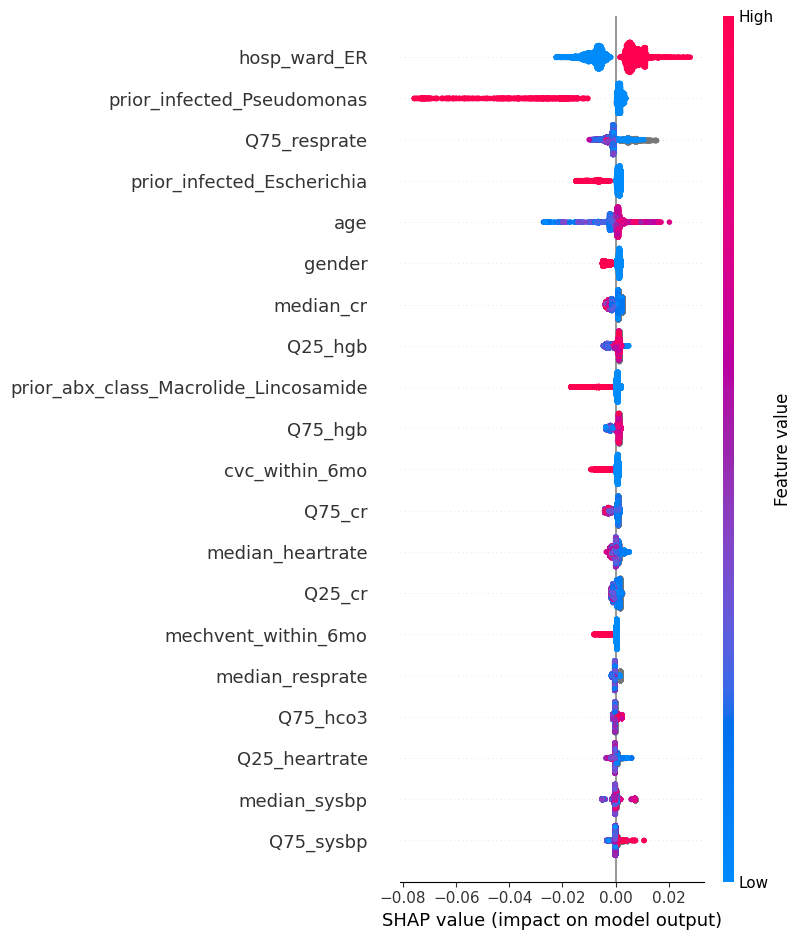

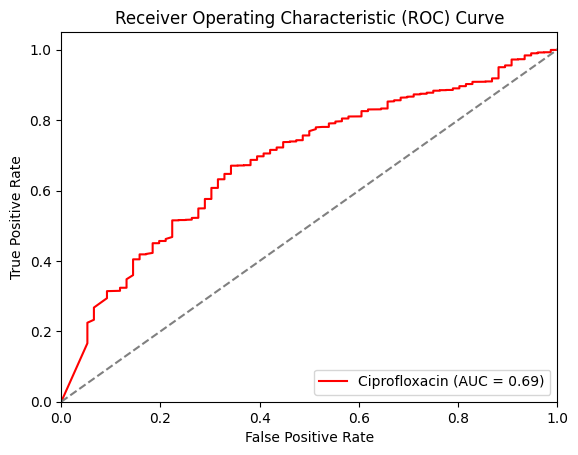

In [ ]:
def plot_shap_importance(model):
    features = model['selected_features']
    model['df_train'].columns = model['df_train'].columns.str.replace(' ', '_')
    model['df_test'].columns = model['df_test'].columns.str.replace(' ', '_')

    X_train = model['df_train'][features]
    X_test = model['df_test'][features]

    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)

    X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

    explainer = shap.Explainer(model['model'])

    shap_values = explainer.shap_values(X_train)

    shap.summary_plot(shap_values, X_train)


plot_shap_importance(model_ciprofloxacin)

### plot model metrics
fpr1, tpr1 = model_ciprofloxacin['roc']['fpr'], model_ciprofloxacin['roc']['tpr']

roc_auc1 = auc(fpr1, tpr1)

plt.figure()

# plot ciprofloxacin model
plt.plot(fpr1, tpr1, color='red', label=f'Ciprofloxacin (AUC = {roc_auc1:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
